In [1]:
import ultralytics
ultralytics.checks()


Ultralytics YOLOv8.0.208  Python-3.10.6 torch-2.1.0+cpu CPU (Intel Core(TM) i5-4460  3.20GHz)
Setup complete  (4 CPUs, 15.9 GB RAM, 444.0/931.5 GB disk)


In [2]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

from sklearn.model_selection import train_test_split
import shutil

In [3]:
def convert_xml_to_yolo(xml_path, classes_map, output_path):
    # Make sure output path exists
    os.makedirs(output_path, exist_ok=True)

    # For every xml file in dir
    for xml_file in os.listdir(xml_path):
        if xml_file.endswith(".xml"):
            xml_file_path = os.path.join(xml_path, xml_file)

            # Create new .txt file with name of xml_file
            output_file_path = os.path.join(output_path, os.path.splitext(xml_file)[0] + ".txt")

            tree = ET.parse(xml_file_path)
            root = tree.getroot()

            image_width = float(root.find('size/width').text)
            image_height = float(root.find('size/height').text)

            with open(output_file_path, 'w') as output_file:
                for obj in root.findall('object'):
                    class_name = obj.find('name').text
                    if class_name not in classes_map:
                        continue 
                    class_id = classes_map[class_name]

                    # Get bbox coordinates
                    xmin = float(obj.find('bndbox/xmin').text)
                    ymin = float(obj.find('bndbox/ymin').text)
                    xmax = float(obj.find('bndbox/xmax').text)
                    ymax = float(obj.find('bndbox/ymax').text)

                    # Transform to yolo format and normalise by the dimensions of the image
                    x_center = (xmin + xmax) / (2 * image_width)
                    y_center = (ymin + ymax) / (2 * image_height)
                    width = (xmax - xmin) / image_width
                    height = (ymax - ymin) / image_height

                    output_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")


In [4]:
# path to files
images_path = 'datasets/road_sign/images/'
xml_path = 'datasets/road_sign/annotations/'
yolo_path = 'datasets/road_sign/labels/'

classes = {'trafficlight': 0, 'stop': 1, 'speedlimit': 2, 'crosswalk': 3}

convert_xml_to_yolo(xml_path, classes, yolo_path)


Check boxes on image

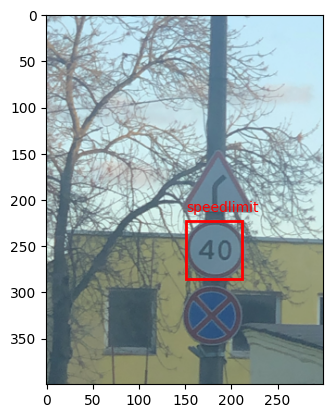

In [5]:
def draw_boxes_on_image(image_path, label_path, classes):
    image = Image.open(image_path)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    with open(label_path, 'r') as txt_file:
        for line in txt_file:
            values = line.strip().split(' ')
            class_id, x_center, y_center, width, height = map(float, values[0:5])

            # Transform yolo to image size
            image_width, image_height = image.size
            x_center *= image_width
            y_center *= image_height
            width *= image_width
            height *= image_height

            # Calculate coordinates of bbox
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            rect_width = width
            rect_height = height

            # Draw rectangle
            rect = plt.Rectangle((x_min, y_min), rect_width, rect_height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Add class label
            class_label = classes.get(int(class_id), f'Class {int(class_id)}')
            plt.text(x_min, y_min - 10, class_label, color='red')

    plt.show()

image_filepath = 'datasets/road_sign/images/road333.png'
label_filepath = 'datasets/road_sign/labels/road333.txt'

classes = {0: 'trafficlight', 1: 'stop', 2: 'speedlimit', 3: 'crosswalk'}

draw_boxes_on_image(image_filepath, label_filepath, classes)


Split the dataset into train-valid-test 

In [6]:
images = [os.path.join('datasets/road_sign/images', x) for x in os.listdir('datasets/road_sign/images')]
annotations = [os.path.join('datasets/road_sign/labels', x) for x in os.listdir('datasets/road_sign/labels')]

images.sort()
annotations.sort()

In [7]:
print(images[:5])
print(annotations[:5])
print(images[-5:])
print(annotations[-5:])

['datasets/road_sign/images\\road0.png', 'datasets/road_sign/images\\road1.png', 'datasets/road_sign/images\\road10.png', 'datasets/road_sign/images\\road100.png', 'datasets/road_sign/images\\road101.png']
['datasets/road_sign/labels\\road0.txt', 'datasets/road_sign/labels\\road1.txt', 'datasets/road_sign/labels\\road10.txt', 'datasets/road_sign/labels\\road100.txt', 'datasets/road_sign/labels\\road101.txt']
['datasets/road_sign/images\\road98.png', 'datasets/road_sign/images\\road99.png', 'datasets/road_sign/images\\test', 'datasets/road_sign/images\\train', 'datasets/road_sign/images\\val']
['datasets/road_sign/labels\\test', 'datasets/road_sign/labels\\train', 'datasets/road_sign/labels\\train.cache', 'datasets/road_sign/labels\\val', 'datasets/road_sign/labels\\val.cache']


In [13]:
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [14]:
def create_folders(dest_folder):
    train_folder = os.path.join(dest_folder, 'train')
    val_folder = os.path.join(dest_folder, 'val')
    test_folder = os.path.join(dest_folder, 'test')

    for folder in [train_folder, val_folder, test_folder]:
        if not os.path.exists(folder):
            os.makedirs(folder)

create_folders('datasets/road_sign/labels/')
create_folders('datasets/road_sign/images/')


In [15]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images,      'datasets/road_sign/images/train/')
move_files_to_folder(val_images,        'datasets/road_sign/images/val/')
move_files_to_folder(test_images,       'datasets/road_sign/images/test/')
move_files_to_folder(train_annotations, 'datasets/road_sign/labels/train/')
move_files_to_folder(val_annotations,   'datasets/road_sign/labels/val/')
move_files_to_folder(test_annotations,  'datasets/road_sign/labels/test/')

In [8]:
print(len(train_images))
print(len(train_annotations))
print(len(val_images))
print(len(val_annotations))
print(len(test_images))
print(len(test_annotations))

NameError: name 'train_images' is not defined

Create road_sing.yaml in dataset/
```yaml
train: ../road_sign/images/train/
val:  ../road_sign/images/val/
test: ../road_sign/images/test/

# number of classes
nc: 4

# class names
names: ["trafficlight","stop", "speedlimit","crosswalk"]
```

Train dataset using yolov8

In [10]:
model = YOLO("yolov8n.pt")
model.train(data="datasets/road_sign.yaml", epochs=40)

Ultralytics YOLOv8.0.208  Python-3.10.6 torch-2.1.0+cpu CPU (Intel Core(TM) i5-4460  3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets/road_sign.yaml, epochs=40, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, o

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002C966E8A110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [16]:
# Load a model
model = YOLO('runs/detect/train/weights/best.pt')  # best trained YOLOv8n model

# Run batched inference on a list of images
results = model(['examples/example1.png', 'examples/example2.png', 'examples/example3.png', 'examples/example4.png'], stream=True)  # return a generator of Results objects

# Process results generator
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    im_array = result.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image


0: 640x640 1 crosswalk, 1: 640x640 3 trafficlights, 1 crosswalk, 2: 640x640 1 trafficlight, 2 speedlimits, 3: 640x640 1 stop, 495.8ms
Speed: 5.5ms preprocess, 124.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


In [15]:
import cv2
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('runs/detect/train/weights/best.pt')

# Open the video file
video_path = "examples/example1.mp4"
cap = cv2.VideoCapture(video_path)

#codec = cv2.VideoWriter_fourcc(*"MJPG")
#out = cv2.VideoWriter('./processed.avi' , codec, 30, (800, 600))

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()
    frame = cv2.resize(frame, (800, 600)) 

    if success:
        # Run YOLOv8 inference on the frame
        results = model(frame)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2.imshow("YOLOv8 Inference", annotated_frame)
        #out.write(annotated_frame)
        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()



0: 480x640 (no detections), 119.0ms
Speed: 3.0ms preprocess, 119.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 145.0ms
Speed: 3.0ms preprocess, 145.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 140.9ms
Speed: 5.0ms preprocess, 140.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 132.0ms
Speed: 3.0ms preprocess, 132.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 126.0ms
Speed: 6.0ms preprocess, 126.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 123.0ms
Speed: 4.0ms preprocess, 123.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 117.0ms
Speed: 3.0ms preprocess, 117.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 109.0ms
Speed: 2.0ms prepr